## Repro [YOLOv5](https://github.com/ultralytics/yolov5)

In [1]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

[WinError 2] The system cannot find the file specified: 'yolov5'
d:\BMU_FINAL PROJECTS\Blood Cell Detection


'git' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\saibu\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [2]:
# for storing labels (.txt) converted from annotation (.xml)
!mkdir -p Dataset/BCCD/Labels 

The syntax of the command is incorrect.


## Create Dataset

In [3]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [4]:
FILE_ROOT = "D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/"

IMAGE_SET_ROOT = FILE_ROOT + "BCCD/ImageSets/Main"  
IMAGE_PATH = FILE_ROOT + "BCCD/JPEGImages"  
ANNOTATIONS_PATH = FILE_ROOT + "BCCD/Annotations"

DATA_ROOT = "D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/"
LABELS_ROOT = DATA_ROOT + "BCCD/Labels"

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

In [5]:
classes = ['Platelets', 'RBC', 'WBC']

### convert annotations (from COCO .xml to YOLO format .txt)

In [6]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0]) # find class_id

        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    print("img_name:", img_name)
    print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [7]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  BloodImage_00000.xml
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00000.xml
img_name: BloodImage_00000.jpg
image_info:(w,h,c) 640 480 3
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Labels/BloodImage_00000.txt
file name:  BloodImage_00001.xml
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00001.xml
img_name: BloodImage_00001.jpg
image_info:(w,h,c) 640 480 3
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Labels/BloodImage_00001.txt
file name:  BloodImage_00002.xml
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00002.xml
img_name: BloodImage_00002.jpg
image_info:(w,h,c) 640 480 3
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Labels/BloodImage_00002.txt
file name:  BloodImage_00003.xml
D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00003.

### copy images & labels

In [8]:
def copy_data(img_set_source, img_labels_root, imgs_source, type):
    file_name = img_set_source + '/' + type + ".txt"
    file = open(file_name)

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for line in file.readlines():
        print(line)
        img_name = line.strip('\n')
        img_sor_file = imgs_source + '/' + img_name + '.jpg'          
        label_sor_file = img_labels_root + '/' + img_name + '.txt'

        # print(img_sor_file)
        # print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.jpg'

        copyfile(img_sor_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_sor_file, img_dict_file)

In [9]:
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "train")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "val")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "test")

Path D:\BMU_FINAL PROJECTS\Blood Cell Detection\BCCD_Dataset-master\images\train is not exit
BloodImage_00001

BloodImage_00003

BloodImage_00004

BloodImage_00005

BloodImage_00006

BloodImage_00008

BloodImage_00009

BloodImage_00010

BloodImage_00012

BloodImage_00013

BloodImage_00020

BloodImage_00022

BloodImage_00023

BloodImage_00024

BloodImage_00026

BloodImage_00032

BloodImage_00034

BloodImage_00036

BloodImage_00038

BloodImage_00039

BloodImage_00040

BloodImage_00042

BloodImage_00043

BloodImage_00044

BloodImage_00045

BloodImage_00046

BloodImage_00047

BloodImage_00048

BloodImage_00049

BloodImage_00050

BloodImage_00052

BloodImage_00054

BloodImage_00056

BloodImage_00059

BloodImage_00069

BloodImage_00070

BloodImage_00071

BloodImage_00076

BloodImage_00078

BloodImage_00079

BloodImage_00081

BloodImage_00082

BloodImage_00083

BloodImage_00086

BloodImage_00087

BloodImage_00090

BloodImage_00091

BloodImage_00092

BloodImage_00094

BloodImage_00095

BloodIm

In [10]:
print(len(os.listdir('D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/dataset/images/train')))
print(len(os.listdir('D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/dataset/images/val')))
print(len(os.listdir('D:/BMU_FINAL PROJECTS/Blood Cell Detection/BCCD_Dataset-master/dataset/images/test')))

205
87
72


## Create data/bccd.yaml

In [11]:
!echo "train: Dataset/images/train\n" > data/bccd.yaml
!echo "val:   Dataset/images/val\n" >> data/bccd.yaml
!echo "nc : 3\n" >> data/bccd.yaml
!echo "names: ['Platelets', 'RBC', 'WBC']\n" >> data/bccd.yaml

!cat data/bccd.yaml

train: Dataset/images/train

val:   Dataset/images/val

nc : 3

names: ['Platelets', 'RBC', 'WBC']



## Train YOLOv5

In [12]:
!python train.py --img 640 --batch 8 --epochs 300 --data data/bccd.yaml --cfg models/yolov5s.yaml

2020-12-18 20:29:57.439644: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
100%|██████████████████████████████████████| 14.5M/14.5M [00:00<00:00, 18.9MB/s]

Scanning 'Dataset/labels/train' for images and labels... 205 found, 0 missing, 0
Scanning 'Dataset/labels/train.cache' for images and labels... 205 found, 0 miss
Scanning 'Dataset/labels/val' for images and labels... 87 found, 0 missing, 0 em
Scanning 'Dataset/labels/val.cache' for images and labels... 87 found, 0 missing

Analyzing anchors... anchors/target = 5.78, Best Possible Recall (BPR) = 0.9996
     0/299      2.5G    0.1073    0.1655   0.04197    0.3148       161       640
               Class      Images     Targets           P           R      mAP@.5
                 all          87    1.14e+03           0           0     0.00324    0.000476
     1/299     2.48G   0.09815     0.171   0.03748    0.3067       117       640
               Class      Image

## YOLOv5 Detect

In [13]:
!python detect.py --source Dataset/images/test --img-size 640 --conf 0.4 --weights runs/train/exp/weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='Dataset/images/test', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00007.jpg: 480x640 1 Plateletss, 9 RBCs, 1 WBCs, Done. (0.013s)
image 2/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00011.jpg: 480x640 16 RBCs, 1 WBCs, Done. (0.011s)
image 3/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00015.jpg: 480x640 2 Plateletss, 16 RBCs, 1 WBCs, Done. (0.014s)
image 4/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00016.jpg: 480x640 15 RBCs, 1 WBCs, Done. (0.011s)
image 5/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00018.jpg: 480x640 16 RBCs, 1 WBCs, Done. (0.011s)
image 6/72 /kaggle/working/yolov5/Dataset/images/test/BloodImage_00019.

In [14]:
from IPython.display import Image

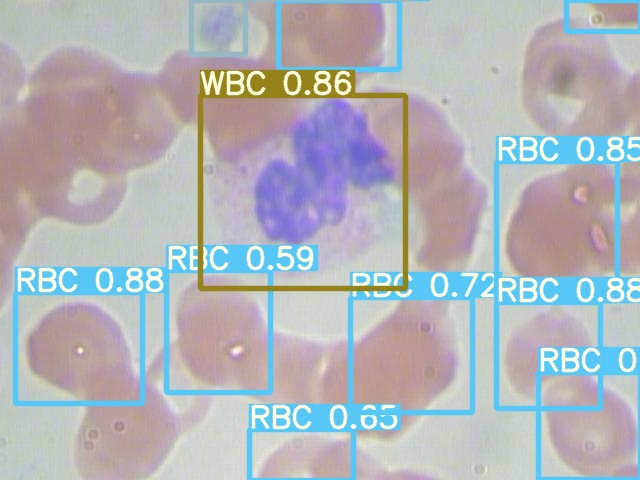

In [15]:
Image('runs/detect/exp/BloodImage_00007.jpg')

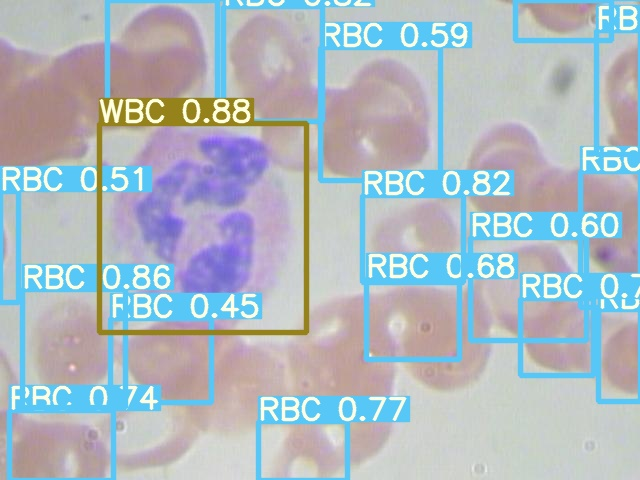

In [16]:
Image('runs/detect/exp/BloodImage_00011.jpg')

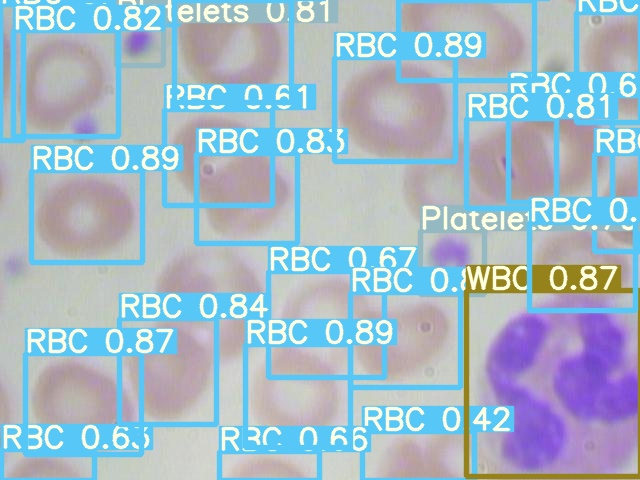

In [17]:
Image('runs/detect/exp/BloodImage_00407.jpg')